In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto, hypergeom
from scipy.optimize import minimize, fsolve, least_squares
import scipy as sc
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

In [2]:
total_liabilites = pd.read_csv(
    'total-liabilities.csv', 
    names=['date', 'value'], 
    skiprows=1, 
    parse_dates=['date'])
total_liabilites.head()

,date,value
0,2002-12-18,702053
1,2002-12-25,713850
2,2003-01-01,714234
3,2003-01-08,706601
4,2003-01-15,702678


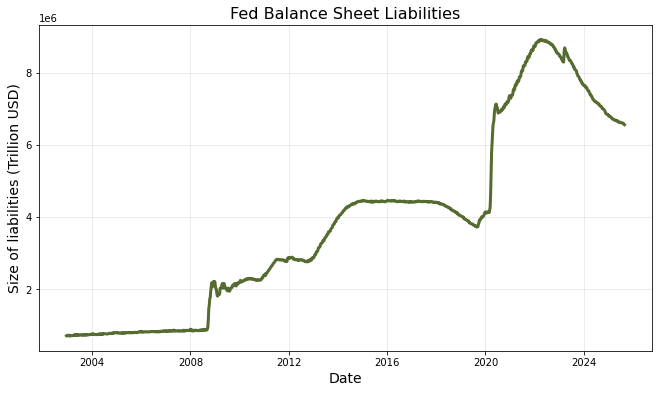

In [3]:
f, ax = plt.subplots(figsize=(11,6))
ax.plot(total_liabilites['date'], total_liabilites['value'], color='darkolivegreen', linewidth=3)

ax.set_ylabel('Size of liabilities (Trillion USD)')
ax.set_xlabel('Date')
ax.set_title('Fed Balance Sheet Liabilities')
ax.grid(alpha=0.3)
plt.show()

In [4]:
tl_latest = total_liabilites[total_liabilites['date'] >= '2023-03-01']

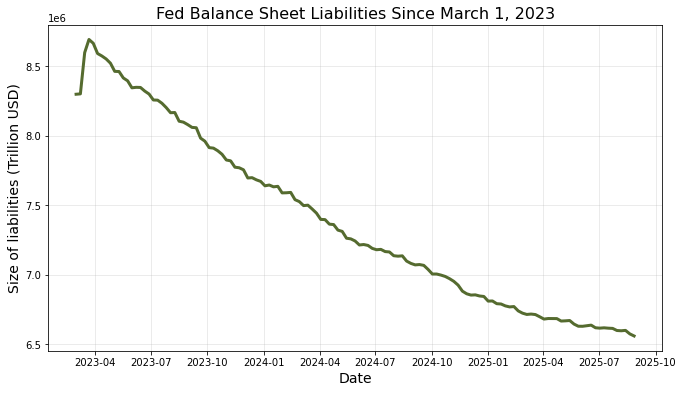

In [5]:
f, ax = plt.subplots(figsize=(11,6))
ax.plot(tl_latest['date'], tl_latest['value'], color='darkolivegreen', linewidth=3)

ax.set_ylabel('Size of liabilities (Trillion USD)')
ax.set_xlabel('Date')
ax.set_title('Fed Balance Sheet Liabilities Since March 1, 2023')
ax.grid(alpha=0.3)
plt.show()

remember, 96% of the fed liabilites is the sum of currency and the fed acct balances, including the treasury balance. let's look at those time series of the same period

In [6]:
currency = pd.read_csv('paper-money.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
reserves = pd.read_csv('reserve-balances.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
treasury = pd.read_csv('treasury-acct.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])

In [7]:
currency_latest = currency[currency['date'] >= '2023-03-01']
reserves_latest = reserves[reserves['date'] >= '2023-03-01']
treasury_latest = treasury[treasury['date'] >= '2023-03-01']
treasury_nearest = pd.merge_asof(
    reserves_latest[['date']], treasury_latest, on='date', direction='nearest'
)

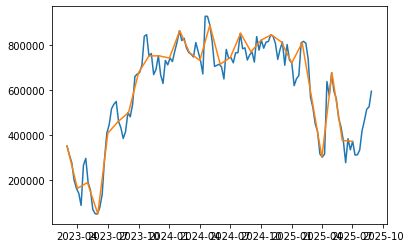

In [11]:
plt.plot(treasury_latest['date'], treasury_latest['value'])
plt.plot(treasury_nearest['date'], treasury_nearest['value'])

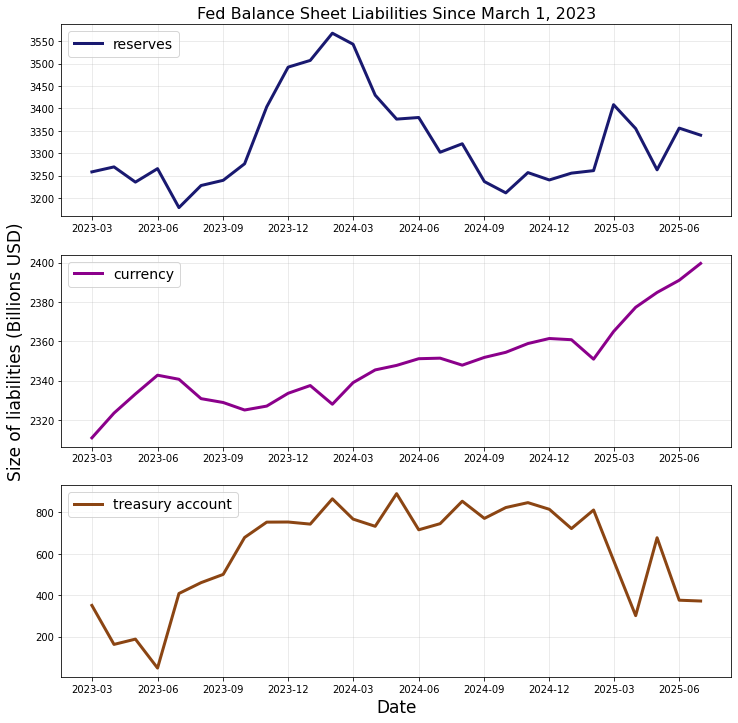

In [54]:
f, axarr = plt.subplots(nrows=3, figsize=(12,12))
axarr[0].plot(reserves_latest['date'], reserves_latest['value'], color='midnightblue', linewidth=3, 
        label='reserves')
axarr[1].plot(currency_latest['date'], currency_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency')
axarr[2].plot(treasury_nearest['date'], treasury_nearest['value']/int(1e3), color='saddlebrown', linewidth=3, 
        label='treasury account')

axarr[2].set_xlabel('Date', size=17)
axarr[1].set_ylabel('Size of liabilities (Billions USD)', size=17)
axarr[0].set_title('Fed Balance Sheet Liabilities Since March 1, 2023')

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
for ax in axarr:
    ax.legend(loc=2, fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime("%Y-%m"))
    ax.grid(alpha=0.3)


# ax.legend()
plt.show()

In [27]:
total = (treasury_nearest['value'].values /int(1e3) 
         + currency_latest['value'].values 
         + reserves_latest['value'].values)

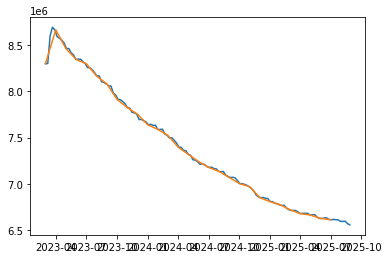

In [44]:
liabilities_nearest = pd.merge_asof(
    reserves_latest[['date']], tl_latest, on='date', direction='nearest'
)

plt.plot(tl_latest['date'], tl_latest['value'])
plt.plot(liabilities_nearest['date'], liabilities_nearest['value'])

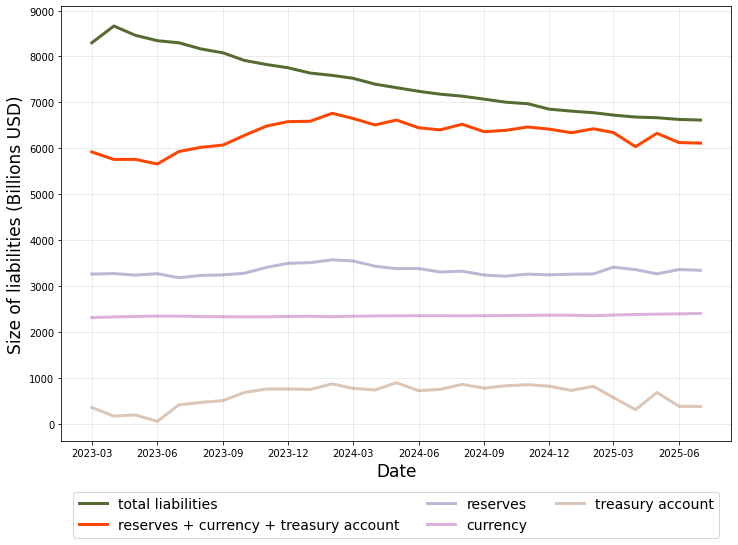

In [57]:
f, ax = plt.subplots(figsize=(12,8))

ax.plot(liabilities_nearest['date'], liabilities_nearest['value']/int(1e3), 
              color='darkolivegreen', linewidth=3, label='total liabilities')
ax.plot(treasury_nearest['date'], total, color='orangered', linewidth=3, 
        label='reserves + currency + treasury account')

ax.plot(reserves_latest['date'], reserves_latest['value'], color='midnightblue', linewidth=3, 
        label='reserves', alpha=0.3)
ax.plot(currency_latest['date'], currency_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency', alpha=0.3)
ax.plot(treasury_nearest['date'], treasury_nearest['value']/int(1e3), color='saddlebrown', linewidth=3, 
        label='treasury account', alpha=0.3)



ax.set_xlabel('Date', size=17)
ax.set_ylabel('Size of liabilities (Billions USD)', size=17)

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime("%Y-%m"))

ax.legend(
    loc="upper center",      # place relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, -0.1),  # center it below the x-axis
    ncol=3,                  # split into 2 columns
    fontsize=14,
)
ax.set_title('Fed Balance Sheet Liabilities Since March 1, 2023, comb', size)
ax.grid(alpha=0.3)
ax.set_yticks(np.arange(0, 9001, 1000))

plt.show()